# Applying DMD for transient modeling, surrogates and Uncertainty Quantificaton.

## 2D LRA Benchmark: 

In this test case, a control rod ejection in the 2D well known LRA benchmark has been simulated by Detran (developed by J. A. Roberts). The objective here is to build a data-driven, yet physics-revealing time-dependent surrogate model(s). The linearity inherited from the connection to Koopman theory will facilitate a forward/backward uncertainty propagation. 

First of all, lets make the necessary imports including the DMD class from PyDMD (developed by math)we import the DMD class from the pydmd package, we set matplotlib for the notebook and we import numpy.

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import scipy as sp
from pydmd import DMD_jov,MrDMD,FbDMD,HODMD
import pickle

We load the Detran simulation data of the Transient LRA Benchmark

In [160]:
A = pickle.load(open('../inputs/diffusion2x2_ref_with_mesh_temps.p','rb'),encoding='latin')

In [161]:
#%% Plots of raw data
t = np.array(A['times'])   # time
mp = np.array(A['meshpower']).T # mesh-dependent powers
p = np.array(A['power'])# total power
c = p[0]/sp.sum(mp,axis=0)[0]# use to reconstruct power from mesh power
maxtemp = A['maxtemp']#
np.where(p==max(p))

(array([143], dtype=int64),)

Text(0,0.5,'Total Power')

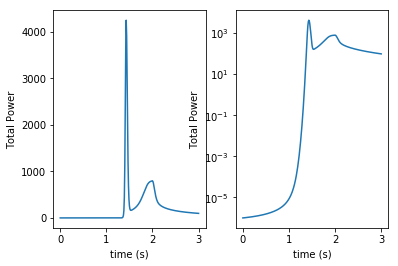

In [162]:
fig1=plt.figure()
ax1 = fig1.add_subplot(121)
ax1.plot(t, p)
plt.xlabel('time (s)')
plt.ylabel('Total Power')
ax2 = fig1.add_subplot(122)
ax2.semilogy(t, p)
plt.xlabel('time (s)')
plt.ylabel('Total Power')

In [163]:
# Single surrogate
dmd = DMD_jov(svd_rank=50,opt='Jov',exact=True)
dmd.fit(mp)
surrogate={}
surrogate['dmd'] = dmd
surrogate['t'] = t # All the coming lines can be ommitted except p_dmd
surrogate['Phi'] = dmd.modes
surrogate['eigs'] = dmd.eigs
surrogate['mp_dmd'] = dmd.reconstructed_data
surrogate['p_dmd'] = sp.zeros(len(t))
surrogate['p_dmd'] = c*sp.sum(dmd.reconstructed_data.real,axis=0)
surrogate['Phi'].shape

C:\ProgramData\Anaconda3\lib\site-packages\pydmd-0.1.0-py3.6.egg\pydmd\dmd_jov.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  Vand[:, k] = eigs**(k)


(484, 50)

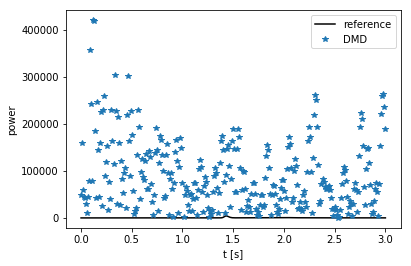

In [164]:
fig0=plt.figure()
plt.plot(t, p, 'k-', label='reference')
plt.plot(surrogate['t'], (abs(surrogate['p_dmd'].real)), '*', label='DMD')
plt.xlabel('t [s]')
plt.ylabel('power')
plt.legend()


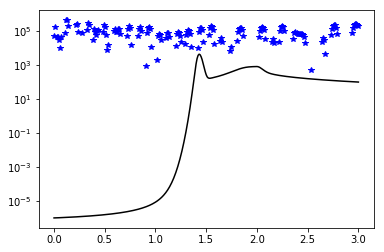

In [165]:
fig2=plt.figure()
plt.semilogy(t, p, 'k-', label='reference')
plt.semilogy(t, c*sp.sum(surrogate['mp_dmd'],axis=0).real, '*b', label='DMD Surrogate')

In [166]:
# Single surrogate
# fbdmd = FbDMD(svd_rank=100)
# fbdmd.fit(mp.T)
# surrogatefb={}
# surrogatefb['dmd'] = fbdmd
# surrogatefb['t'] = t # All the coming lines can be ommitted except p_dmd
# surrogatefb['Phi'] = fbdmd.modes
# surrogatefb['eigs'] = fbdmd.eigs
# surrogatefb['mp_dmd'] = fbdmd.reconstructed_data
# surrogatefb['p_dmd'] = sp.zeros(len(t))
# surrogatefb['p_dmd'] = c*sp.sum((fbdmd.reconstructed_data.real),axis=0)

In [167]:
# fig0=plt.figure()
# plt.plot(t, p, 'k-', label='reference')
# plt.plot(t, (surrogatefb['p_dmd'].real), '*', label='FbDMD')
# plt.xlabel('t [s]')
# plt.axis([0, 3, 0, 5000])
# plt.ylabel('power')
# plt.legend()


In [168]:
# # Single surrogate
# mrdmd = MrDMD(svd_rank=-1, max_level=3, max_cycles=2)
# mrdmd.fit([mp])
# surrogatemr={}
# surrogatemr['dmd'] = mrdmd
# surrogatemr['t'] = t # All the coming lines can be ommitted except p_dmd
# surrogatemr['Phi'] = mrdmd.modes
# surrogatemr['eigs'] = mrdmd.eigs
# surrogatemr['mp_dmd'] = mrdmd.reconstructed_data
# surrogatemr['p_dmd'] = sp.zeros(len(t))
# surrogatemr['p_dmd'] = c*sp.sum(mrdmd.reconstructed_data.real,axis=0)

Build the surrogates using a batch of DMD's

In [169]:
#%%  DMD analysis

# Time step
dt = t[1]-t[0]
# Chop the time domain into discrete patches
#time_interval = [1.16,1.37,1.5,max(t)]
time_interval = [1.36,1.5,max(t)]
#time_interval = [1.37,1.5,max(t)]


# Define desire subspace size for each patch
r = [10,13,35]
#r = [50,1e5,15]
#step=[10,1,1]
optimal=['Jov',False,False]
# Perform dmd
time_index = [0]
for i in range(len(time_interval)):
    time_index.append(sp.sum(t<=time_interval[i]))

results={}
for i in range(len(time_interval)):
    start, stop = time_index[i], time_index[i+1]
    t_i = t[start:stop]
    #t_i = t[start:stop:step[i]]
    
    #t = np.linspace(t[start], t[stop], len(t_i))
    #x = np.linspace(0, 484, 484)
    #xgrid, tgrid = np.meshgrid(x, t)

    
    dmd = DMD_jov(svd_rank=r[i],opt=optimal[i])
    dmd.fit(mp[:,start:stop])
#    counter=0
#    for eig in dmd.eigs:
#        if np.abs(eig.imag**2+eig.real**2)>4:
#            dmd.eigs[counter]=1.0
#        counter+=1
    results[i]={}
    results[i]['dmd'] = dmd
    results[i]['t'] = t_i # All the coming lines can be ommitted except p_dmd
    results[i]['Phi'] = dmd.modes
    results[i]['eigs'] = dmd.eigs
    results[i]['mp_dmd'] = dmd.reconstructed_data
    results[i]['p_dmd'] = sp.zeros(stop-start)
    results[i]['p_dmd'] = c*sp.sum(dmd.reconstructed_data.real,axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\pydmd-0.1.0-py3.6.egg\pydmd\dmd_jov.py:69: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(modes, snapshots.T[0])[0]


One can inspect the temporal behaviour of the system from the data. specifically, from the eigenvalues. The location of the eigen value on the argand plane dectates, stability, convergence or divergence. If the eigen value is located on the unit circle, it is stable, if it is inside it will converge, and if it is outside, it will diverge. 

Eigenvalue 9.560759542333571: distance from unit circle 90.40812302632243
Eigenvalue 5.573548151465478: distance from unit circle 30.064438996704247
Eigenvalue 3.2567815117565093: distance from unit circle 9.606625815319013
Eigenvalue 2.3641545322125084: distance from unit circle 4.589226652180944
Eigenvalue 1.8000081843805955: distance from unit circle 2.240029463837128
Eigenvalue 1.4028474009628815: distance from unit circle 0.9679808303883117
Eigenvalue 1.1302619805908578: distance from unit circle 0.2774921447691687
Eigenvalue 0.9964884521518725: distance from unit circle 0.007010764727965246
Eigenvalue 0.9998170706143007: distance from unit circle 0.0003658253082384766
Eigenvalue 1.0145650175409988: distance from unit circle 0.029342174817967193


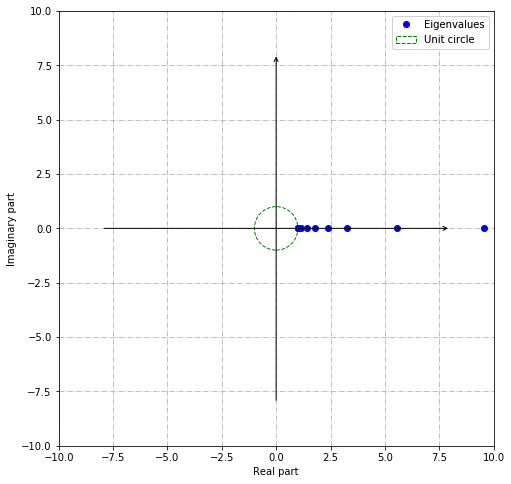

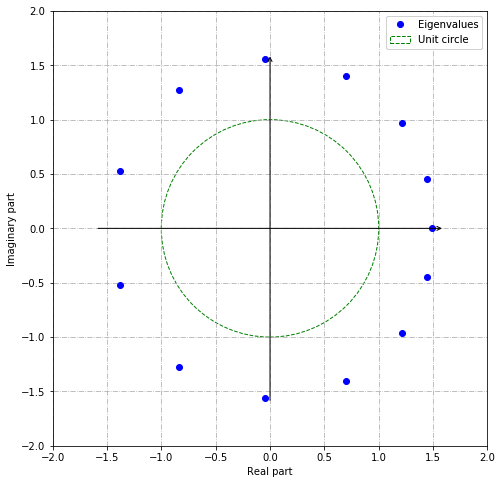

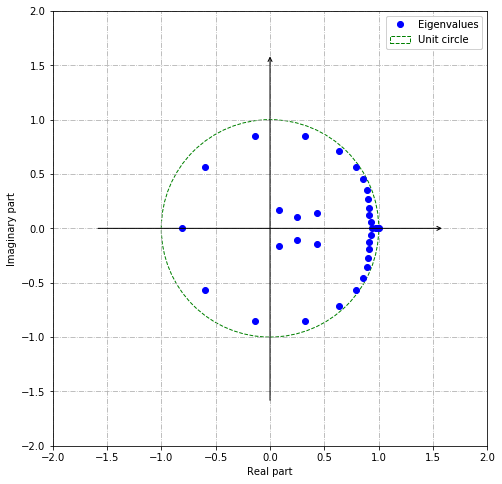

In [170]:
#print("dmd for times {:.2e}--{:.2e}".format(results[0]['t'][0], results[0]['t'][-1])) 
fig2=plt.figure()
#ax1=fig2.add_subplot(1,3,1)
for eig in results[0]['eigs']:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))
for j in range(len(time_interval)): 
    results[j]['dmd'].plot_eigs(show_axes=True, show_unit_circle=True)

#ax2=fig2.add_subplot(1,3,2)
#print("dmd for times {:.2e}--{:.2e}".format(results[1]['t'][0], results[1]['t'][-1])) 
#for eig in results[1]['eigs']:
#    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))
#results[1]['dmd'].plot_eigs(show_axes=True, show_unit_circle=True)

#ax3=fig2.add_subplot(1,3,3)
#print("dmd for times {:.2e}--{:.2e}".format(results[2]['t'][0], results[2]['t'][-1])) 
#for eig in results[2]['eigs']:
#    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))
#results[2]['dmd'].plot_eigs(show_axes=True, show_unit_circle=True)

### Spatial Stability Analysis:

In [171]:
#E=np.linalg.eigvals(mp.T)
##for e in E:
#plt.plot(e.real,e.imag,'*')

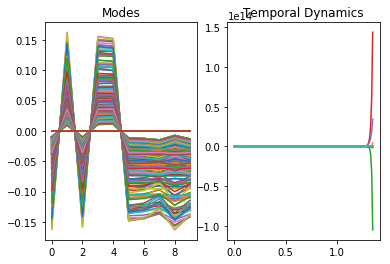

In [172]:
fig2=plt.figure()
ax1 = fig2.add_subplot(121)
for mode in results[0]['Phi']:
    ax1.plot( mode.real)
    plt.title('Modes')
ax2 = fig2.add_subplot(122)
for dynamic in results[0]['dmd'].dynamics:
    ax2.plot(results[0]['t'], dynamic.real)
    plt.title('Temporal Dynamics')
plt.show()

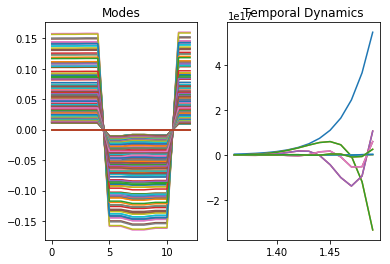

In [173]:
fig3=plt.figure()
ax1 = fig3.add_subplot(121)
for mode in results[1]['Phi']:
    plt.plot( mode.real)
    plt.title('Modes')
ax2 = fig3.add_subplot(122)
for dynamic in results[1]['dmd'].dynamics:
    plt.plot(results[1]['t'], dynamic.real)
    plt.title('Temporal Dynamics')
plt.show()

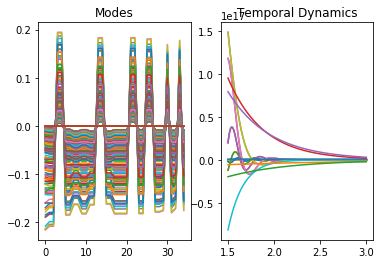

In [174]:
fig4=plt.figure()
ax1 = fig4.add_subplot(121)
for mode in results[2]['Phi']:
    plt.plot( mode.real)
    plt.title('Modes')
ax2 = fig4.add_subplot(122)
for dynamic in results[2]['dmd'].dynamics:
    plt.plot(results[2]['t'], dynamic.real)
    plt.title('Temporal Dynamics')
plt.show()

In [175]:
# fig4=plt.figure()
# ax1 = fig4.add_subplot(121)
# for mode in results[3]['Phi']:
#     plt.plot( mode.real)
#     plt.title('Modes')
# ax2 = fig4.add_subplot(122)
# for dynamic in results[3]['dmd'].dynamics:
#     plt.plot(results[3]['t'], dynamic.real)
#     plt.title('Temporal Dynamics')
# plt.show()

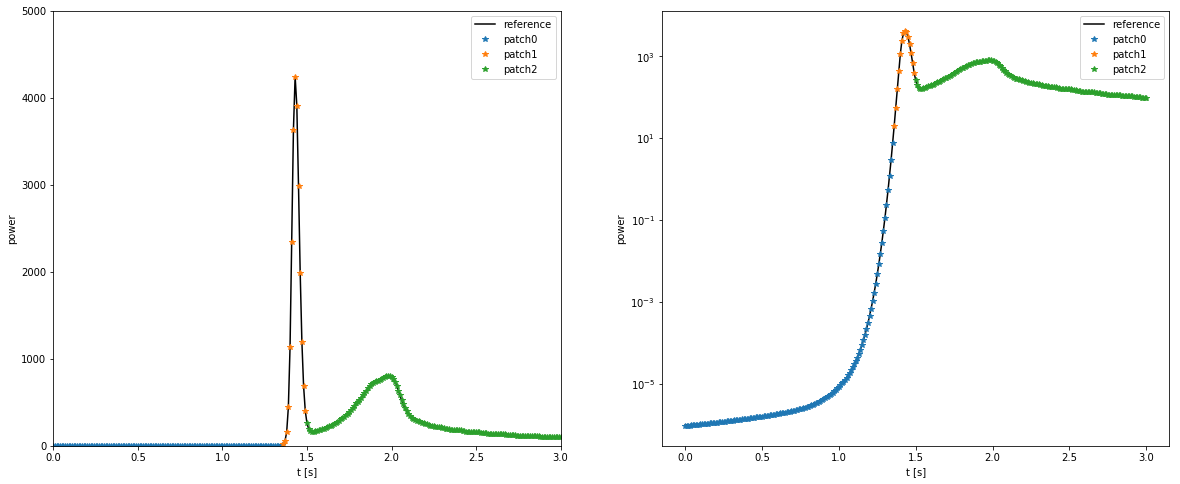

In [176]:
#for mode in dmd.modes.T:
#    plt.plot(x, mode.real)
#    plt.title('Modes')
#plt.show()T.real)
    
#plt.pcolor(xgrid, tgrid, ((mp[start:stop, :].T-dmd.reconstructed_data).T).real)
#fig = plt.colorbar()

fig5=plt.figure(figsize=(20,8))
ax1=fig5.add_subplot(1,2,1)
plt.plot(t, p, 'k-', label='reference')
for k in range(len(time_interval)):
    plt.plot(results[k]['t'], results[k]['p_dmd'].real, '*', label='patch'+str(k))    
plt.axis([0, 3, 0, 5000])
plt.xlabel('t [s]')
plt.ylabel('power')
plt.legend()

ax2=fig5.add_subplot(1,2,2)  
plt.semilogy(t, p, 'k-', label='reference')
for k in range(len(time_interval)):
    plt.semilogy(results[k]['t'], results[k]['p_dmd'].real, '*', label='patch'+str(k))
plt.xlabel('t [s]')
plt.ylabel('power')
plt.legend()
plt.show()
plt.savefig('../images/meshpower_surrogate.pdf')

In [177]:
Xdmd_2D=np.reshape(np.concatenate((results[0]['mp_dmd'],results[1]['mp_dmd'],results[2]['mp_dmd']),axis=1),(22,22,-1),order='F')
mp_2D=np.reshape(mp,(22,22,-1),order='F')

In [178]:
X,Y=np.linspace(0,23,22),np.linspace(0,23,22)

In [179]:
xgrid,ygrid=np.meshgrid(X,Y)

In [180]:
Xdmd_2D[:,:,0].shape,mp_2D[:,:,0].shape

((22, 22), (22, 22))

t=0


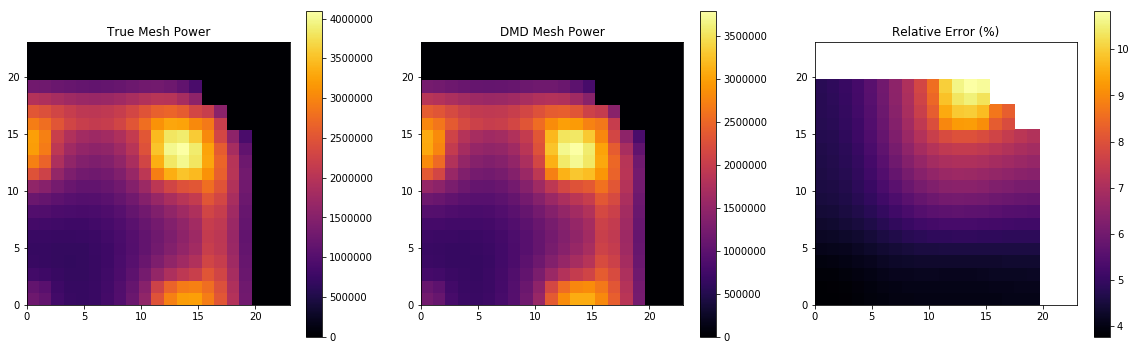

In [181]:
print('t=0')
fig = plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,3,2)
ax1.set_aspect('equal')
plt.pcolor(xgrid, ygrid, Xdmd_2D[:,:,0].real,cmap='inferno')
plt.colorbar()
plt.title('DMD Mesh Power')
ax2=fig.add_subplot(1,3,1)
ax2.set_aspect('equal')
plt.pcolor(xgrid, ygrid, mp_2D[:,:,0].real,cmap='inferno')
plt.colorbar()
plt.title('True Mesh Power')
ax3=fig.add_subplot(1,3,3)
ax3.set_aspect('equal')
plt.pcolor(xgrid, ygrid, (mp_2D[:,:,0].real-Xdmd_2D[:,:,0].real)/mp_2D[:,:,0].real*100,cmap='inferno')
plt.colorbar()
plt.title('Relative Error (%)')

plt.show()
plt.savefig('../images/Initial_spatial_power_colorMap')

t=1.43


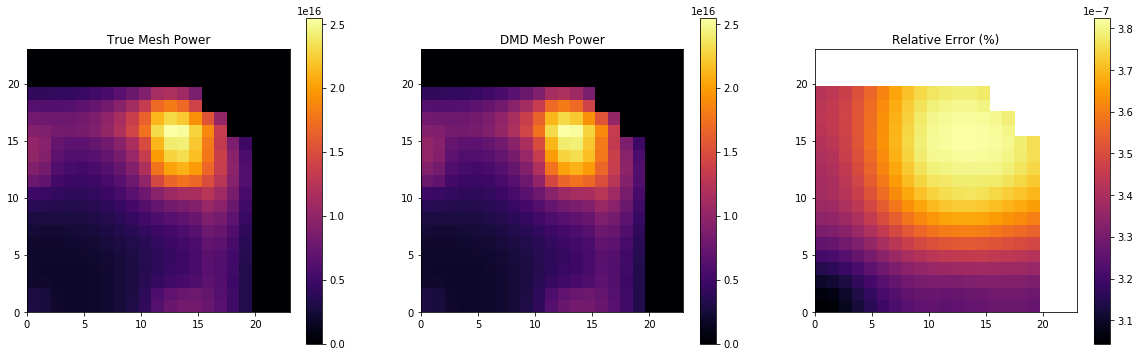

In [182]:
print('t=1.43')
t_pmax = 143
fig = plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,3,2)
ax1.set_aspect('equal')
plt.pcolor(xgrid, ygrid, Xdmd_2D[:,:,t_pmax].real,cmap='inferno')
plt.colorbar()
plt.title('DMD Mesh Power')
ax2=fig.add_subplot(1,3,1)
ax2.set_aspect('equal')
plt.pcolor(xgrid, ygrid, mp_2D[:,:,t_pmax].real,cmap='inferno')
plt.colorbar()
plt.title('True Mesh Power')
ax3=fig.add_subplot(1,3,3)
ax3.set_aspect('equal')
plt.pcolor(xgrid, ygrid, (mp_2D[:,:,t_pmax].real-Xdmd_2D[:,:,t_pmax].real)/mp_2D[:,:,t_pmax].real*100,cmap='inferno')
plt.colorbar()
plt.title('Relative Error (%)')

plt.show()
plt.savefig('../images/MaxP_spatial_power_colorMap')

t=2.5


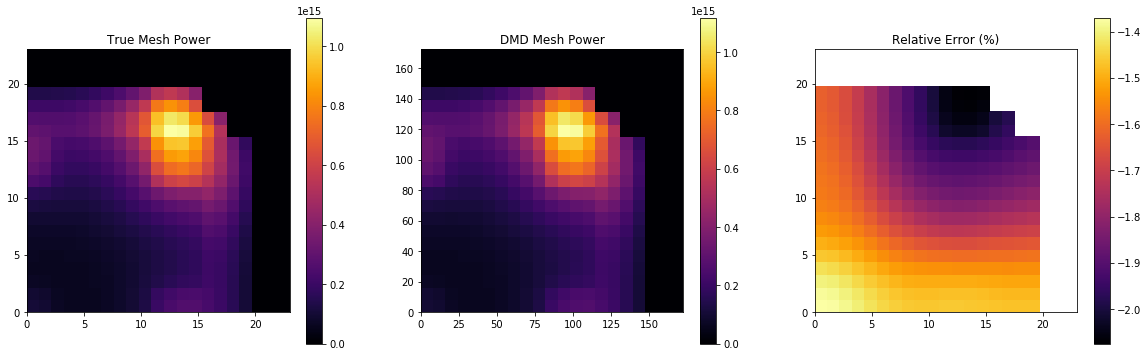

In [183]:
print('t=2.5')
fig = plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,3,2)
ax1.set_aspect('equal')
plt.pcolor(7.5*xgrid, 7.5*ygrid, Xdmd_2D[:,:,250].real,cmap='inferno')
plt.colorbar()
plt.title('DMD Mesh Power')
ax2=fig.add_subplot(1,3,1)
ax2.set_aspect('equal')
plt.pcolor(xgrid, ygrid, mp_2D[:,:,250].real,cmap='inferno')
plt.colorbar()
plt.title('True Mesh Power')
ax3=fig.add_subplot(1,3,3)
ax3.set_aspect('equal')
plt.pcolor(xgrid, ygrid, (mp_2D[:,:,250].real-Xdmd_2D[:,:,250].real)/mp_2D[:,:,250].real*100,cmap='inferno')
plt.colorbar()
plt.title('Relative Error (%)')
plt.show()
plt.savefig('../images/secondhump_spatial_power_colorMap')

t=3


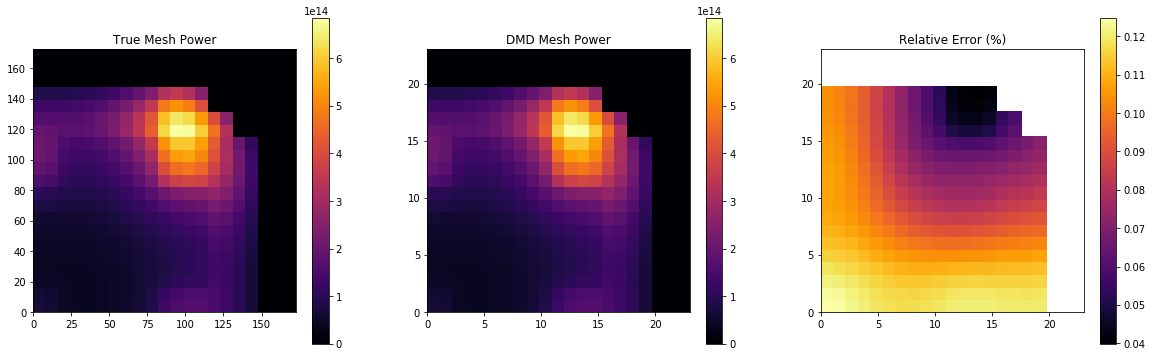

In [184]:
print('t=3')
fig = plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,3,2)
ax1.set_aspect('equal')
plt.pcolor(xgrid, ygrid, Xdmd_2D[:,:,-1].real,cmap='inferno')
plt.colorbar()
plt.title('DMD Mesh Power')
ax2=fig.add_subplot(1,3,1)
ax2.set_aspect('equal')
plt.pcolor(7.5*xgrid, 7.5*ygrid, mp_2D[:,:,-1].real,cmap='inferno')
plt.colorbar()
plt.title('True Mesh Power')
ax3=fig.add_subplot(1,3,3)
ax3.set_aspect('equal')
plt.pcolor(xgrid, ygrid, (mp_2D[:,:,-1].real-Xdmd_2D[:,:,-1].real)/mp_2D[:,:,-1].real*100,cmap='inferno')
plt.colorbar()
plt.title('Relative Error (%)')
plt.show()
plt.savefig('../images/end_spatial_power_colorMap')